In [176]:
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import geopandas as gpd
import contextily as cx
import os
os.environ['PROJ_LIB'] = r'/Users/chenyangkang/miniforge3/share/proj'

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.metrics import recall_score, precision_score, average_precision_score, roc_auc_score,\
                            cohen_kappa_score,f1_score,precision_recall_curve,PrecisionRecallDisplay
                            

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from quadtree import *
from filter_data_script import *
from AdaSTEM_classifier_utiles import *
from get_variable_dict import *

In [4]:
#### checklist data (location, time, environmental variables...)
checklist_feature = pickle.load(open('American_snapshot_10_10_500_each_grid.pkl','rb'))
checklist_feature = filter_data(checklist_feature,2018)

In [6]:
##### get variable list
variable_dict = get_variable_dict()
variable_dict.keys()

dict_keys(['sampling_variables', 'time_variables', 'landscape_variables', 'climate_variables', 'land_use_variables'])

In [7]:
##### overall there are 105 predictors
all_variable_names = []
for i in variable_dict.values():
    all_variable_names.extend(i)
len(all_variable_names)


105

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
eval_df = {
    'sp':[],
    # '':[],
    'recall':[],
    'precision':[],
    'average_precision':[],
    'roc_auc':[],
    'cohen_kappa':[],
    'f1':[]
}

model_dict = {}

for sp in ['American_Crow', 'American_Robin', 'Turkey_Vulture', 'Mallard', 'Black-capped_Chickadee', 'House_Wren']:
    print(sp)
    #### species count data
    sp_data = pickle.load(open(f'./sp_count/{sp}_2018.pkl','rb'))
    #### merge them
    data = pd.merge(checklist_feature, sp_data, on='sampling_event_identifier', how='left')
    data['count'] = data['count'].fillna(0)
    data['count'] = np.where(data['count']>0,1,0)

    X = data[all_variable_names+['longitude','latitude','sampling_event_identifier']]
    y = data['count']

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    base_model = XGBClassifier(random_state=42,eval_metric='logloss')
    model = AdaSTEM(base_model = base_model,
                    ensemble_fold=8,
                    grid_len_long_upper_threshold=25,
                    grid_len_long_lower_threshold=10,
                    grid_len_lat_upper_threshold=25,
                    grid_len_lat_lower_threshold=10,
                    points_lower_threshold=50
                    )
    model.fit(X_train,y_train)

    pred = model.predict_proba(X_test)
    y_test_m = y_test[~np.isnan(pred)]
    pred_m = np.where(pred[~np.isnan(pred)]>0.05,1,0)

    eval_df['sp'].append(sp)
    eval_df['recall'].append(recall_score(y_test_m, pred_m))
    eval_df['precision'].append(precision_score(y_test_m, pred_m))
    eval_df['average_precision'].append(average_precision_score(y_test_m, pred_m))
    eval_df['roc_auc'].append(roc_auc_score(y_test_m, pred_m))
    eval_df['cohen_kappa'].append(cohen_kappa_score(y_test_m, pred_m))
    eval_df['f1'].append(f1_score(y_test_m, pred_m))

    model_dict[sp]=model
    break



American_Crow
ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.22it/s] 


## permutation/feature importance analysis

In [16]:
X_test.columns

Index(['duration_minutes', 'Traveling', 'Stationary', 'Area',
       'obsvr_species_count', 'DOY', 'month', 'week', 'year',
       'time_observation_started_minute_of_day',
       ...
       'water_bodies_lpi', 'water_bodies_pd', 'woody_savannas',
       'woody_savannas_ed', 'woody_savannas_lpi', 'woody_savannas_pd',
       'entropy', 'longitude', 'latitude', 'sampling_event_identifier'],
      dtype='object', length=108)

In [34]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

##### ori score
pred = model.predict_proba(X_test)
y_test_m = y_test[~np.isnan(pred)]
pred_m = np.where(pred[~np.isnan(pred)]>0.05,1,0)

ori_score = roc_auc_score(
    y_test_m, pred_m
)

##### permu test
permu_scores = {

}


for index,feature in enumerate(all_variable_names):
    
    scores = []
    for rep in range(5):
        print(index+1, feature, rep)
        X_temp = X_test.copy()
        X_temp[feature] = X_temp[feature].sample(frac=1,replace=False).values
        pred = model.predict_proba(X_temp)
        y_test_m = y_test[~np.isnan(pred)]
        pred_m = np.where(pred[~np.isnan(pred)]>0.05,1,0)

        scores.append(roc_auc_score(
                                    y_test_m, pred_m
                                ))
    permu_scores[feature] = scores





predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.52it/s]


1 duration_minutes 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.26it/s]


1 duration_minutes 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.60it/s]


1 duration_minutes 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.72it/s]


1 duration_minutes 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.47it/s]


1 duration_minutes 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 83.64it/s]


2 Traveling 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 96.85it/s] 


2 Traveling 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.46it/s] 


2 Traveling 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 88.55it/s]


2 Traveling 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.86it/s]


2 Traveling 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.96it/s]


3 Stationary 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.13it/s]


3 Stationary 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 88.85it/s]


3 Stationary 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.63it/s]


3 Stationary 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.75it/s]


3 Stationary 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.50it/s]


4 Area 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.57it/s]


4 Area 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.66it/s]


4 Area 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.45it/s] 


4 Area 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.74it/s]


4 Area 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.29it/s]


5 obsvr_species_count 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.56it/s] 


5 obsvr_species_count 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.47it/s]


5 obsvr_species_count 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.08it/s]


5 obsvr_species_count 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.91it/s]


5 obsvr_species_count 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.13it/s] 


6 DOY 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.87it/s] 


6 DOY 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.99it/s] 


6 DOY 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.30it/s]


6 DOY 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.11it/s] 


6 DOY 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.95it/s]


7 month 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.89it/s] 


7 month 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.88it/s]


7 month 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.43it/s]


7 month 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.68it/s]


7 month 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.12it/s]


8 week 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.08it/s]


8 week 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.10it/s] 


8 week 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.52it/s]


8 week 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.15it/s]


8 week 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.72it/s]


9 year 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.44it/s]


9 year 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.22it/s]


9 year 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.17it/s] 


9 year 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.28it/s]


9 year 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.13it/s]


10 time_observation_started_minute_of_day 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.67it/s]


10 time_observation_started_minute_of_day 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.42it/s]


10 time_observation_started_minute_of_day 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:08<00:00, 74.64it/s]


10 time_observation_started_minute_of_day 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 87.16it/s]


10 time_observation_started_minute_of_day 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.89it/s]


11 elevation_mean 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.68it/s]


11 elevation_mean 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.66it/s]


11 elevation_mean 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.37it/s]


11 elevation_mean 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.78it/s] 


11 elevation_mean 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.96it/s]


12 slope_mean 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.47it/s]


12 slope_mean 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.34it/s] 


12 slope_mean 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.05it/s]


12 slope_mean 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 82.49it/s]


12 slope_mean 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.51it/s]


13 eastness_mean 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.79it/s] 


13 eastness_mean 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.21it/s] 


13 eastness_mean 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.91it/s]


13 eastness_mean 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.20it/s] 


13 eastness_mean 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.23it/s] 


14 northness_mean 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.10it/s] 


14 northness_mean 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.66it/s] 


14 northness_mean 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.05it/s] 


14 northness_mean 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.11it/s] 


14 northness_mean 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.65it/s] 


15 elevation_std 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.41it/s] 


15 elevation_std 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.09it/s] 


15 elevation_std 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.35it/s] 


15 elevation_std 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.65it/s] 


15 elevation_std 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.77it/s] 


16 slope_std 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.24it/s] 


16 slope_std 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.16it/s] 


16 slope_std 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.78it/s] 


16 slope_std 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.45it/s] 


16 slope_std 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.05it/s] 


17 eastness_std 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.48it/s] 


17 eastness_std 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.51it/s]


17 eastness_std 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.55it/s] 


17 eastness_std 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.45it/s]


17 eastness_std 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.71it/s] 


18 northness_std 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.73it/s] 


18 northness_std 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.93it/s] 


18 northness_std 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.81it/s] 


18 northness_std 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.33it/s] 


18 northness_std 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.46it/s] 


19 prec 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.15it/s] 


19 prec 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.46it/s] 


19 prec 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.77it/s] 


19 prec 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.79it/s] 


19 prec 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.28it/s] 


20 tmax 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.49it/s] 


20 tmax 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.25it/s] 


20 tmax 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.08it/s] 


20 tmax 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.64it/s]


20 tmax 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.01it/s] 


21 tmin 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.83it/s] 


21 tmin 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.02it/s] 


21 tmin 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.29it/s] 


21 tmin 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.66it/s] 


21 tmin 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.93it/s] 


22 bio1 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.56it/s] 


22 bio1 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.51it/s] 


22 bio1 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.43it/s] 


22 bio1 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.27it/s] 


22 bio1 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.52it/s] 


23 bio2 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.04it/s] 


23 bio2 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.62it/s] 


23 bio2 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.53it/s] 


23 bio2 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.45it/s] 


23 bio2 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.64it/s] 


24 bio3 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.04it/s] 


24 bio3 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.98it/s] 


24 bio3 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.37it/s]


24 bio3 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.66it/s] 


24 bio3 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.97it/s] 


25 bio4 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.27it/s] 


25 bio4 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.84it/s] 


25 bio4 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.23it/s] 


25 bio4 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.54it/s] 


25 bio4 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.79it/s] 


26 bio5 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 96.26it/s] 


26 bio5 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.96it/s] 


26 bio5 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.05it/s] 


26 bio5 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.05it/s] 


26 bio5 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.53it/s] 


27 bio6 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.83it/s] 


27 bio6 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.29it/s] 


27 bio6 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.44it/s] 


27 bio6 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.00it/s] 


27 bio6 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.75it/s] 


28 bio7 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.57it/s] 


28 bio7 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.85it/s] 


28 bio7 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.04it/s] 


28 bio7 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.45it/s] 


28 bio7 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.78it/s] 


29 bio8 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.56it/s] 


29 bio8 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.68it/s] 


29 bio8 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 75.89it/s]


29 bio8 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 81.52it/s]


29 bio8 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 87.01it/s]


30 bio9 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.85it/s] 


30 bio9 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.23it/s] 


30 bio9 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.06it/s] 


30 bio9 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.52it/s] 


30 bio9 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.82it/s] 


31 bio10 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.44it/s] 


31 bio10 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.44it/s] 


31 bio10 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.79it/s] 


31 bio10 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 85.27it/s]


31 bio10 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 88.97it/s]


32 bio11 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.84it/s]


32 bio11 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.71it/s] 


32 bio11 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.97it/s] 


32 bio11 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.17it/s] 


32 bio11 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.14it/s] 


33 bio12 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.66it/s] 


33 bio12 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.54it/s] 


33 bio12 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.64it/s] 


33 bio12 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.52it/s] 


33 bio12 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.30it/s] 


34 bio13 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.88it/s] 


34 bio13 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.28it/s] 


34 bio13 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.72it/s] 


34 bio13 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.54it/s] 


34 bio13 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.51it/s]


35 bio14 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.23it/s] 


35 bio14 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.72it/s] 


35 bio14 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.99it/s]


35 bio14 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.69it/s] 


35 bio14 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.12it/s] 


36 bio15 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.71it/s]


36 bio15 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.18it/s] 


36 bio15 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.02it/s] 


36 bio15 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.92it/s] 


36 bio15 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.88it/s]


37 bio16 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.78it/s] 


37 bio16 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:08<00:00, 74.14it/s] 


37 bio16 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.17it/s] 


37 bio16 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 96.68it/s] 


37 bio16 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.83it/s] 


38 bio17 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.20it/s] 


38 bio17 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.39it/s] 


38 bio17 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.43it/s] 


38 bio17 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.97it/s] 


38 bio17 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.35it/s] 


39 bio18 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 84.93it/s] 


39 bio18 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.13it/s] 


39 bio18 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.06it/s] 


39 bio18 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.66it/s] 


39 bio18 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.53it/s]


40 bio19 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 86.05it/s]


40 bio19 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 76.48it/s]


40 bio19 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.18it/s]


40 bio19 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.09it/s]


40 bio19 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.69it/s] 


41 closed_shrublands 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.01it/s]


41 closed_shrublands 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.55it/s]


41 closed_shrublands 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 83.43it/s]


41 closed_shrublands 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.03it/s] 


41 closed_shrublands 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 80.62it/s]


42 closed_shrublands_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:08<00:00, 73.15it/s]


42 closed_shrublands_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.63it/s] 


42 closed_shrublands_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.54it/s] 


42 closed_shrublands_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.58it/s] 


42 closed_shrublands_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.94it/s] 


43 closed_shrublands_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.26it/s] 


43 closed_shrublands_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.39it/s] 


43 closed_shrublands_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.06it/s]


43 closed_shrublands_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.28it/s] 


43 closed_shrublands_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.74it/s] 


44 closed_shrublands_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.63it/s] 


44 closed_shrublands_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.08it/s] 


44 closed_shrublands_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.84it/s] 


44 closed_shrublands_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.15it/s] 


44 closed_shrublands_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.68it/s] 


45 cropland_or_natural_vegetation_mosaics 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.59it/s] 


45 cropland_or_natural_vegetation_mosaics 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.98it/s] 


45 cropland_or_natural_vegetation_mosaics 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.11it/s] 


45 cropland_or_natural_vegetation_mosaics 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.56it/s] 


45 cropland_or_natural_vegetation_mosaics 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.02it/s] 


46 cropland_or_natural_vegetation_mosaics_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.93it/s] 


46 cropland_or_natural_vegetation_mosaics_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.00it/s] 


46 cropland_or_natural_vegetation_mosaics_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.61it/s] 


46 cropland_or_natural_vegetation_mosaics_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.64it/s] 


46 cropland_or_natural_vegetation_mosaics_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.70it/s] 


47 cropland_or_natural_vegetation_mosaics_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.04it/s]


47 cropland_or_natural_vegetation_mosaics_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.66it/s] 


47 cropland_or_natural_vegetation_mosaics_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.38it/s] 


47 cropland_or_natural_vegetation_mosaics_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.64it/s] 


47 cropland_or_natural_vegetation_mosaics_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.16it/s] 


48 cropland_or_natural_vegetation_mosaics_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.34it/s] 


48 cropland_or_natural_vegetation_mosaics_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.34it/s] 


48 cropland_or_natural_vegetation_mosaics_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.07it/s]


48 cropland_or_natural_vegetation_mosaics_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.14it/s]


48 cropland_or_natural_vegetation_mosaics_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.49it/s] 


49 croplands 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.30it/s]


49 croplands 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.67it/s] 


49 croplands 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.09it/s] 


49 croplands 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.39it/s] 


49 croplands 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.85it/s]


50 croplands_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.86it/s] 


50 croplands_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.76it/s] 


50 croplands_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.10it/s] 


50 croplands_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.78it/s] 


50 croplands_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.93it/s] 


51 croplands_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.30it/s] 


51 croplands_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.95it/s] 


51 croplands_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.97it/s] 


51 croplands_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.12it/s] 


51 croplands_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.18it/s] 


52 croplands_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.80it/s] 


52 croplands_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.93it/s] 


52 croplands_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.17it/s] 


52 croplands_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.54it/s] 


52 croplands_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.31it/s] 


53 deciduous_broadleaf_forests 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.29it/s] 


53 deciduous_broadleaf_forests 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.58it/s] 


53 deciduous_broadleaf_forests 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.17it/s]


53 deciduous_broadleaf_forests 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.69it/s] 


53 deciduous_broadleaf_forests 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.24it/s] 


54 deciduous_broadleaf_forests_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.57it/s] 


54 deciduous_broadleaf_forests_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.63it/s] 


54 deciduous_broadleaf_forests_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.48it/s] 


54 deciduous_broadleaf_forests_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.35it/s] 


54 deciduous_broadleaf_forests_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.09it/s] 


55 deciduous_broadleaf_forests_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.24it/s] 


55 deciduous_broadleaf_forests_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.80it/s]


55 deciduous_broadleaf_forests_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.30it/s] 


55 deciduous_broadleaf_forests_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.50it/s] 


55 deciduous_broadleaf_forests_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.30it/s] 


56 deciduous_broadleaf_forests_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.07it/s] 


56 deciduous_broadleaf_forests_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.67it/s] 


56 deciduous_broadleaf_forests_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.30it/s] 


56 deciduous_broadleaf_forests_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.63it/s] 


56 deciduous_broadleaf_forests_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.14it/s] 


57 deciduous_needleleaf_forests 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.02it/s] 


57 deciduous_needleleaf_forests 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.29it/s] 


57 deciduous_needleleaf_forests 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 84.13it/s]


57 deciduous_needleleaf_forests 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.67it/s] 


57 deciduous_needleleaf_forests 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.60it/s]


58 deciduous_needleleaf_forests_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.27it/s] 


58 deciduous_needleleaf_forests_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.65it/s] 


58 deciduous_needleleaf_forests_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.68it/s] 


58 deciduous_needleleaf_forests_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.61it/s] 


58 deciduous_needleleaf_forests_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.74it/s] 


59 deciduous_needleleaf_forests_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.34it/s]


59 deciduous_needleleaf_forests_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.70it/s] 


59 deciduous_needleleaf_forests_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.68it/s] 


59 deciduous_needleleaf_forests_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.75it/s] 


59 deciduous_needleleaf_forests_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.95it/s] 


60 deciduous_needleleaf_forests_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.32it/s] 


60 deciduous_needleleaf_forests_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.51it/s] 


60 deciduous_needleleaf_forests_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.26it/s] 


60 deciduous_needleleaf_forests_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.43it/s] 


60 deciduous_needleleaf_forests_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.91it/s] 


61 evergreen_broadleaf_forests 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.69it/s] 


61 evergreen_broadleaf_forests 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.38it/s] 


61 evergreen_broadleaf_forests 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.46it/s] 


61 evergreen_broadleaf_forests 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.29it/s] 


61 evergreen_broadleaf_forests 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.11it/s] 


62 evergreen_broadleaf_forests_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.76it/s] 


62 evergreen_broadleaf_forests_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.19it/s] 


62 evergreen_broadleaf_forests_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.50it/s] 


62 evergreen_broadleaf_forests_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.51it/s]


62 evergreen_broadleaf_forests_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.85it/s] 


63 evergreen_broadleaf_forests_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.18it/s] 


63 evergreen_broadleaf_forests_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.48it/s] 


63 evergreen_broadleaf_forests_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.74it/s] 


63 evergreen_broadleaf_forests_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.84it/s] 


63 evergreen_broadleaf_forests_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.31it/s] 


64 evergreen_broadleaf_forests_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.69it/s] 


64 evergreen_broadleaf_forests_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.38it/s] 


64 evergreen_broadleaf_forests_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.83it/s] 


64 evergreen_broadleaf_forests_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.29it/s] 


64 evergreen_broadleaf_forests_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.03it/s] 


65 evergreen_needleleaf_forests 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.85it/s] 


65 evergreen_needleleaf_forests 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.05it/s] 


65 evergreen_needleleaf_forests 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.31it/s] 


65 evergreen_needleleaf_forests 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.13it/s] 


65 evergreen_needleleaf_forests 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:08<00:00, 68.96it/s]


66 evergreen_needleleaf_forests_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.48it/s] 


66 evergreen_needleleaf_forests_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.46it/s] 


66 evergreen_needleleaf_forests_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.60it/s] 


66 evergreen_needleleaf_forests_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.16it/s] 


66 evergreen_needleleaf_forests_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.84it/s] 


67 evergreen_needleleaf_forests_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.15it/s] 


67 evergreen_needleleaf_forests_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.93it/s] 


67 evergreen_needleleaf_forests_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.13it/s] 


67 evergreen_needleleaf_forests_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.86it/s]


67 evergreen_needleleaf_forests_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.93it/s] 


68 evergreen_needleleaf_forests_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.12it/s]


68 evergreen_needleleaf_forests_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.90it/s] 


68 evergreen_needleleaf_forests_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.27it/s] 


68 evergreen_needleleaf_forests_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.78it/s] 


68 evergreen_needleleaf_forests_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.07it/s] 


69 grasslands 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.52it/s] 


69 grasslands 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.43it/s] 


69 grasslands 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.55it/s] 


69 grasslands 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.35it/s] 


69 grasslands 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.14it/s] 


70 grasslands_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.41it/s] 


70 grasslands_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.55it/s] 


70 grasslands_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.82it/s] 


70 grasslands_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.07it/s] 


70 grasslands_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.57it/s] 


71 grasslands_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.22it/s] 


71 grasslands_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.12it/s] 


71 grasslands_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.99it/s] 


71 grasslands_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.63it/s] 


71 grasslands_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.81it/s] 


72 grasslands_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.57it/s] 


72 grasslands_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.01it/s] 


72 grasslands_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.11it/s] 


72 grasslands_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 86.86it/s]


72 grasslands_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 80.40it/s]


73 mixed_forests 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 88.99it/s] 


73 mixed_forests 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.09it/s] 


73 mixed_forests 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 75.56it/s]


73 mixed_forests 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.56it/s] 


73 mixed_forests 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.46it/s] 


74 mixed_forests_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.57it/s] 


74 mixed_forests_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.70it/s] 


74 mixed_forests_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.13it/s] 


74 mixed_forests_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.06it/s] 


74 mixed_forests_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.90it/s] 


75 mixed_forests_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.35it/s]


75 mixed_forests_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.17it/s] 


75 mixed_forests_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.99it/s]


75 mixed_forests_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.02it/s] 


75 mixed_forests_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:08<00:00, 74.93it/s]


76 mixed_forests_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 88.87it/s]


76 mixed_forests_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.93it/s] 


76 mixed_forests_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 86.14it/s]


76 mixed_forests_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.57it/s] 


76 mixed_forests_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.56it/s] 


77 non_vegetated_lands 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.23it/s] 


77 non_vegetated_lands 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.28it/s] 


77 non_vegetated_lands 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.45it/s] 


77 non_vegetated_lands 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 88.65it/s]


77 non_vegetated_lands 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.17it/s]


78 non_vegetated_lands_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.75it/s] 


78 non_vegetated_lands_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.40it/s]


78 non_vegetated_lands_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.05it/s]


78 non_vegetated_lands_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.64it/s]


78 non_vegetated_lands_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.87it/s]


79 non_vegetated_lands_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.74it/s]


79 non_vegetated_lands_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.12it/s]


79 non_vegetated_lands_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.31it/s]


79 non_vegetated_lands_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.62it/s] 


79 non_vegetated_lands_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.14it/s] 


80 non_vegetated_lands_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.97it/s] 


80 non_vegetated_lands_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.92it/s] 


80 non_vegetated_lands_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.42it/s]


80 non_vegetated_lands_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.71it/s] 


80 non_vegetated_lands_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.24it/s]


81 open_shrublands 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.94it/s] 


81 open_shrublands 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 88.76it/s]


81 open_shrublands 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.65it/s]


81 open_shrublands 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.86it/s] 


81 open_shrublands 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 88.78it/s]


82 open_shrublands_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.82it/s]


82 open_shrublands_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.46it/s]


82 open_shrublands_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.04it/s] 


82 open_shrublands_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.28it/s] 


82 open_shrublands_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.13it/s]


83 open_shrublands_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.44it/s] 


83 open_shrublands_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 85.38it/s]


83 open_shrublands_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.31it/s]


83 open_shrublands_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.77it/s] 


83 open_shrublands_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.91it/s]


84 open_shrublands_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.41it/s]


84 open_shrublands_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.13it/s]


84 open_shrublands_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.14it/s]


84 open_shrublands_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.24it/s] 


84 open_shrublands_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.96it/s]


85 permanent_wetlands 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.73it/s] 


85 permanent_wetlands 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.23it/s] 


85 permanent_wetlands 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.74it/s]


85 permanent_wetlands 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.14it/s]


85 permanent_wetlands 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.48it/s] 


86 permanent_wetlands_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.63it/s]


86 permanent_wetlands_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.87it/s]


86 permanent_wetlands_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.76it/s]


86 permanent_wetlands_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.72it/s]


86 permanent_wetlands_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.32it/s]


87 permanent_wetlands_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.28it/s] 


87 permanent_wetlands_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.43it/s] 


87 permanent_wetlands_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.01it/s] 


87 permanent_wetlands_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.10it/s] 


87 permanent_wetlands_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.26it/s] 


88 permanent_wetlands_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 77.50it/s]


88 permanent_wetlands_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 78.30it/s]


88 permanent_wetlands_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.11it/s] 


88 permanent_wetlands_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 81.69it/s]


88 permanent_wetlands_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 82.30it/s]


89 savannas 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 79.31it/s] 


89 savannas 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:08<00:00, 71.17it/s]


89 savannas 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 88.99it/s] 


89 savannas 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 78.46it/s]


89 savannas 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 76.05it/s]


90 savannas_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 88.21it/s]


90 savannas_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 82.73it/s] 


90 savannas_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 77.02it/s]


90 savannas_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:08<00:00, 68.92it/s]


90 savannas_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.57it/s] 


91 savannas_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.89it/s] 


91 savannas_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 83.44it/s] 


91 savannas_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 85.38it/s]


91 savannas_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 85.26it/s]


91 savannas_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.82it/s] 


92 savannas_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 81.35it/s]


92 savannas_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.52it/s] 


92 savannas_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.97it/s]


92 savannas_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.63it/s]


92 savannas_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.30it/s]


93 urban_and_built_up_lands 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.07it/s] 


93 urban_and_built_up_lands 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.92it/s]


93 urban_and_built_up_lands 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.98it/s]


93 urban_and_built_up_lands 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 77.08it/s]


93 urban_and_built_up_lands 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.93it/s] 


94 urban_and_built_up_lands_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.12it/s] 


94 urban_and_built_up_lands_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.96it/s]


94 urban_and_built_up_lands_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.38it/s] 


94 urban_and_built_up_lands_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.34it/s] 


94 urban_and_built_up_lands_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.04it/s] 


95 urban_and_built_up_lands_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.81it/s] 


95 urban_and_built_up_lands_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.56it/s] 


95 urban_and_built_up_lands_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.82it/s] 


95 urban_and_built_up_lands_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.41it/s] 


95 urban_and_built_up_lands_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 87.58it/s] 


96 urban_and_built_up_lands_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:08<00:00, 71.41it/s]


96 urban_and_built_up_lands_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.70it/s] 


96 urban_and_built_up_lands_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 89.81it/s] 


96 urban_and_built_up_lands_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.94it/s] 


96 urban_and_built_up_lands_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.94it/s] 


97 water_bodies 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.57it/s] 


97 water_bodies 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.02it/s] 


97 water_bodies 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.97it/s] 


97 water_bodies 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.09it/s] 


97 water_bodies 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.22it/s] 


98 water_bodies_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.52it/s] 


98 water_bodies_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.66it/s] 


98 water_bodies_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.59it/s] 


98 water_bodies_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.91it/s] 


98 water_bodies_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 92.08it/s] 


99 water_bodies_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 91.56it/s] 


99 water_bodies_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.47it/s] 


99 water_bodies_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.15it/s] 


99 water_bodies_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.54it/s] 


99 water_bodies_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.58it/s] 


100 water_bodies_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.59it/s] 


100 water_bodies_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.49it/s] 


100 water_bodies_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.14it/s] 


100 water_bodies_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.74it/s] 


100 water_bodies_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.54it/s] 


101 woody_savannas 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.73it/s] 


101 woody_savannas 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.04it/s] 


101 woody_savannas 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.02it/s] 


101 woody_savannas 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.58it/s] 


101 woody_savannas 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.15it/s] 


102 woody_savannas_ed 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.74it/s] 


102 woody_savannas_ed 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.76it/s]


102 woody_savannas_ed 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.64it/s] 


102 woody_savannas_ed 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.62it/s] 


102 woody_savannas_ed 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.43it/s] 


103 woody_savannas_lpi 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.54it/s] 


103 woody_savannas_lpi 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.59it/s] 


103 woody_savannas_lpi 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:07<00:00, 82.51it/s]


103 woody_savannas_lpi 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.40it/s] 


103 woody_savannas_lpi 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.81it/s] 


104 woody_savannas_pd 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.94it/s] 


104 woody_savannas_pd 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.99it/s] 


104 woody_savannas_pd 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.07it/s]


104 woody_savannas_pd 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 94.26it/s] 


104 woody_savannas_pd 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.78it/s] 


105 entropy 0


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.89it/s] 


105 entropy 1


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.49it/s] 


105 entropy 2


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 95.14it/s] 


105 entropy 3


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 93.81it/s] 


105 entropy 4


predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 90.05it/s] 


In [194]:
###### importance by permutation
feature_importance = pd.DataFrame({
    'mean':pd.DataFrame(permu_scores).mean(),
    'std':pd.DataFrame(permu_scores).std()
})

feature_importance['mean'] = (ori_score-feature_importance['mean'])/ori_score

feature_importance = feature_importance.sort_values(by='mean',ascending=False)



##### importance by model
importances = []
for k in model.model_dict.keys():
    model_ = model.model_dict[k]
    try:
        importances.append(model_.feature_importances_)
    except:
        continue

importances = np.array(importances)

feature_importance_by_model_output = pd.DataFrame(
{
        'feature':model.x_names,
    'importance':importances.mean(axis=0)
}
)

###### merge
feature_importance = pd.concat([feature_importance,
        feature_importance_by_model_output.set_index('feature')],axis=1).rename(columns={
            'mean':'mean_by_permutation',
            'std':'std_by_permutation',
            'importance':'mean_by_model_output'
            })

feature_importance.to_csv('feature_importance.csv',index=True)

In [109]:
feature_importance

,mean_by_permutation,std_by_permutation,mean_by_model_output
DOY,0.033025,0.001321,0.012264
elevation_mean,0.008047,0.000360,0.024815
duration_minutes,0.007047,0.000603,0.015389
bio4,0.006694,0.000231,0.044084
slope_mean,0.004379,0.000301,0.018442
...,...,...,...
water_bodies_lpi,-0.000020,0.000011,0.003449
non_vegetated_lands,-0.000025,0.000007,0.004355
croplands_lpi,-0.000026,0.000058,0.005564
evergreen_needleleaf_forests_lpi,-0.000042,0.000085,0.006288


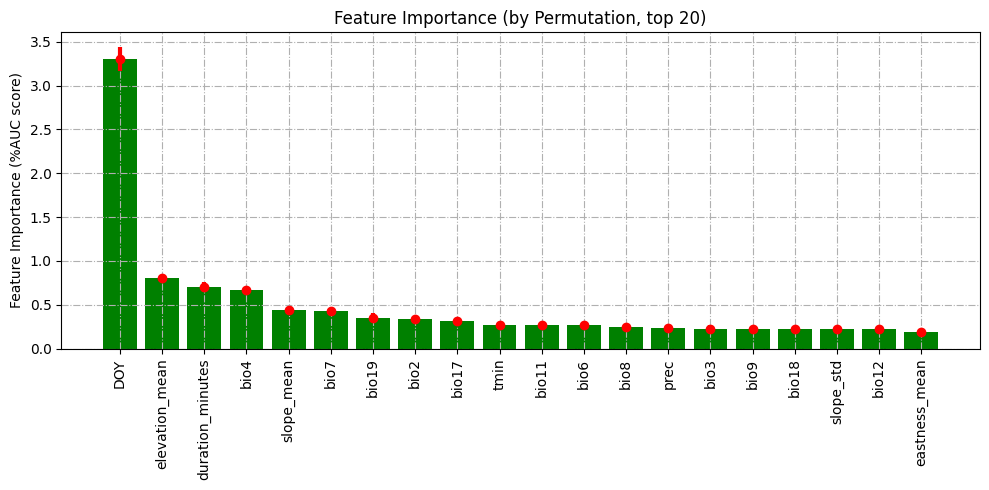

In [191]:
# importing matplotlib
import matplotlib.pyplot as plt

# making a simple plot
plt.figure(figsize=(10,5))
plt.bar(feature_importance.head(20).index,
        feature_importance.head(20)['mean_by_permutation']*100,color='green')

plt.errorbar(feature_importance.head(20).index,
        feature_importance.head(20)['mean_by_permutation']*100, 
        yerr=feature_importance.head(20)['std_by_permutation']*100, fmt="o", color="red",linewidth=3)

plt.xticks(rotation=90)
plt.ylabel('Feature Importance (%AUC score)')
plt.title('Feature Importance (by Permutation, top 20)')
plt.grid(linestyle = "-.")
plt.tight_layout()


plt.savefig('Feature_importance.png',dpi=500)


plt.show()


In [193]:
feature_importance

,mean_by_permutation,std_by_permutation,mean_by_model_output
DOY,0.033025,0.001321,0.012264
elevation_mean,0.008047,0.000360,0.024815
duration_minutes,0.007047,0.000603,0.015389
bio4,0.006694,0.000231,0.044084
slope_mean,0.004379,0.000301,0.018442
...,...,...,...
water_bodies_lpi,-0.000020,0.000011,0.003449
non_vegetated_lands,-0.000025,0.000007,0.004355
croplands_lpi,-0.000026,0.000058,0.005564
evergreen_needleleaf_forests_lpi,-0.000042,0.000085,0.006288


## Error analysis

In [113]:
pred = model.predict_proba(X_test)
y_test_m = y_test[~np.isnan(pred)]
pred_m = np.where(pred[~np.isnan(pred)]>0.05,1,0)



predicting ensemble 7 : 100%|██████████| 601/601 [00:06<00:00, 87.57it/s]


In [123]:
right_index = y_test_m.index[(y_test_m==pred_m)]
wrong_index = y_test_m.index[(y_test_m!=pred_m)]


In [203]:
from scipy.stats import ttest_1samp


In [211]:
k='DOY'

In [213]:
X_test.loc[right_index][k].values.mean(),a[k]

(167.01563933486239, 132)

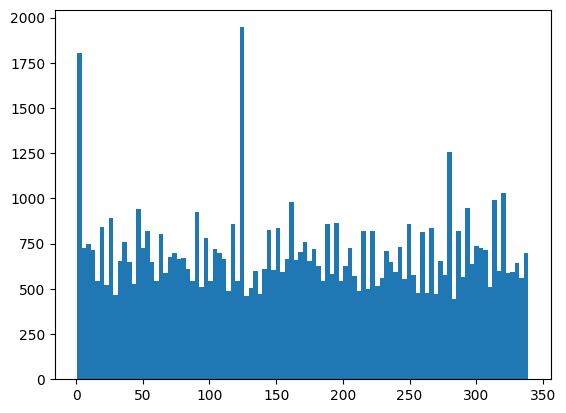

In [217]:
plt.hist(X_test.loc[right_index][k].values,bins=100)
plt.show()

In [215]:
ttest_1samp(
        X_test.loc[right_index][k].values,
        a[k]
    )

Ttest_1sampResult(statistic=93.16356771667577, pvalue=0.0)

In [216]:
a[k]

132

In [219]:
print(np.mean(X_test.loc[right_index]['duration_minutes'].values))
for i in [0,1,2]:
    print(X_test.loc[wrong_index[i]]['duration_minutes'])

92.90116112385321
192.0
12.0
77.0


In [226]:
dict(X_test.loc[wrong_index[3]])

{'duration_minutes': 60.0,
 'Traveling': 1,
 'Stationary': 0,
 'Area': 0,
 'obsvr_species_count': 473,
 'DOY': 217,
 'month': 8,
 'week': 31,
 'year': 2018,
 'time_observation_started_minute_of_day': 1078,
 'elevation_mean': 207.0,
 'slope_mean': 0.17608732,
 'eastness_mean': 0.0065026283,
 'northness_mean': 0.054505024,
 'elevation_std': 0.19923899,
 'slope_std': 0.015178439,
 'eastness_std': 0.010459588,
 'northness_std': 0.010039539,
 'prec': 172.56128,
 'tmax': 28.813194,
 'tmin': 17.519022,
 'bio1': 9.952511,
 'bio2': 10.895364,
 'bio3': 26.822891,
 'bio4': 1107.0,
 'bio5': 29.562725,
 'bio6': -11.056923,
 'bio7': 40.619648,
 'bio8': 19.612038,
 'bio9': -5.8563,
 'bio10': 23.411512,
 'bio11': -3.5006077,
 'bio12': 1152.1523,
 'bio13': 178.5843,
 'bio14': 27.509607,
 'bio15': 3009.8933,
 'bio16': 524.2261,
 'bio17': 117.253006,
 'bio18': 432.6371,
 'bio19': 135.01434,
 'closed_shrublands': 0.0,
 'closed_shrublands_ed': 0.0,
 'closed_shrublands_lpi': 0.0,
 'closed_shrublands_pd': 0.

In [220]:
a = X_test.loc[wrong_index[0]]
for k in dict(a):
    
    t,p=ttest_1samp(
        X_test.loc[right_index][k].values,
        a[k]
    )
    diff = a[k] - X_test.loc[right_index][k].values.mean()
    print(k, p, diff)



duration_minutes 0.0 99.09883887614679
Traveling 0.0 0.30946100917431196
Stationary 0.0 -0.304286123853211
Area 1.0701373077727913e-80 -0.005174885321100917
obsvr_species_count 0.0 1896.350071674312
DOY 1.2666032398951672e-26 -4.015639334862385
month 0.05134680082104757 -0.02398222477064227
week 3.1304586515639846e-06 -0.2502006880733951
year nan 0.0
time_observation_started_minute_of_day 0.0 -81.95622133027518
elevation_mean 0.0 -553.7562452456311
slope_mean 0.0 -3.368642254449944
eastness_mean 0.0 -0.10759112211155823
northness_mean 0.0 0.03347500566596918
elevation_std 0.0 -7.487180224144638
slope_std 0.0 -0.24361478223825006
eastness_std 0.0 0.04748011232950278
northness_std 0.0 0.01847400499415469
prec 0.0 -91.33036904100032
tmax 0.0 -21.2873088780898
tmin 0.0 -11.183121058342724
bio1 0.0 -15.778763944603725
bio2 0.0 -10.914015534407971
bio3 0.0 -48.52572323356508
bio4 0.0 -444.7488637441944
bio5 0.0 -27.308973972019782
bio6 0.0 -4.083620312869044
bio7 0.0 -24.152632911902234
bio8

TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [206]:
ttest_1samp(
        X_test.loc[right_index][k].values,
        a[k]
    )
    

Ttest_1sampResult(statistic=-229.53065419017366, pvalue=0.0)

In [136]:
dist_diff_df = []
for v in tqdm(all_variable_names):
    print(v)
    right_dist = X_test.loc[right_index][v]
    wrong_dist = X_test.loc[wrong_index][v]
    from scipy.stats import ttest_ind

    t,p = ttest_ind(wrong_dist,
            right_dist)

    

    dist_diff_df.append(
        {
        'variable':v,
        'wrong_pred_mean':np.mean(wrong_dist),
        'wrong_pred_std':np.std(wrong_dist),
        'right_pred_mean':np.mean(right_dist),
        'right_pred_std':np.std(right_dist),
        't':t,
        'p':p
        }
    )



  4%|▍         | 4/105 [00:00<00:02, 39.77it/s]

duration_minutes
Traveling
Stationary
Area
obsvr_species_count
DOY
month
week
year


 13%|█▎        | 14/105 [00:00<00:02, 39.50it/s]

time_observation_started_minute_of_day
elevation_mean
slope_mean
eastness_mean
northness_mean
elevation_std
slope_std
eastness_std
northness_std


 26%|██▌       | 27/105 [00:00<00:01, 51.69it/s]

prec
tmax
tmin
bio1
bio2
bio3
bio4
bio5
bio6
bio7
bio8
bio9
bio10


 31%|███▏      | 33/105 [00:00<00:01, 53.20it/s]

bio11
bio12
bio13
bio14
bio15
bio16
bio17
bio18


 42%|████▏     | 44/105 [00:00<00:01, 46.22it/s]

bio19
closed_shrublands
closed_shrublands_ed
closed_shrublands_lpi
closed_shrublands_pd
cropland_or_natural_vegetation_mosaics
cropland_or_natural_vegetation_mosaics_ed
cropland_or_natural_vegetation_mosaics_lpi
cropland_or_natural_vegetation_mosaics_pd
croplands
croplands_ed
croplands_lpi


 54%|█████▍    | 57/105 [00:01<00:00, 52.89it/s]

croplands_pd
deciduous_broadleaf_forests
deciduous_broadleaf_forests_ed
deciduous_broadleaf_forests_lpi
deciduous_broadleaf_forests_pd
deciduous_needleleaf_forests
deciduous_needleleaf_forests_ed
deciduous_needleleaf_forests_lpi
deciduous_needleleaf_forests_pd
evergreen_broadleaf_forests
evergreen_broadleaf_forests_ed
evergreen_broadleaf_forests_lpi


 66%|██████▌   | 69/105 [00:01<00:00, 55.39it/s]

evergreen_broadleaf_forests_pd
evergreen_needleleaf_forests
evergreen_needleleaf_forests_ed
evergreen_needleleaf_forests_lpi
evergreen_needleleaf_forests_pd
grasslands
grasslands_ed
grasslands_lpi
grasslands_pd
mixed_forests
mixed_forests_ed
mixed_forests_lpi
mixed_forests_pd


 79%|███████▉  | 83/105 [00:01<00:00, 59.63it/s]

non_vegetated_lands
non_vegetated_lands_ed
non_vegetated_lands_lpi
non_vegetated_lands_pd
open_shrublands
open_shrublands_ed
open_shrublands_lpi
open_shrublands_pd
permanent_wetlands
permanent_wetlands_ed
permanent_wetlands_lpi
permanent_wetlands_pd
savannas


 92%|█████████▏| 97/105 [00:01<00:00, 61.26it/s]

savannas_ed
savannas_lpi
savannas_pd
urban_and_built_up_lands
urban_and_built_up_lands_ed
urban_and_built_up_lands_lpi
urban_and_built_up_lands_pd
water_bodies
water_bodies_ed
water_bodies_lpi
water_bodies_pd
woody_savannas
woody_savannas_ed


100%|██████████| 105/105 [00:01<00:00, 53.58it/s]

woody_savannas_lpi
woody_savannas_pd
entropy


In [138]:
dist_diff_df = pd.DataFrame(dist_diff_df)




In [141]:
dist_diff_df['wrong_minus_right'] = dist_diff_df['wrong_pred_mean'] - dist_diff_df['right_pred_mean']

In [192]:
dist_diff_df[dist_diff_df['variable'].isin(
    feature_importance.head(20).index
)].sort_values(by='p').to_csv('Error_analysis_features.csv',index=False)


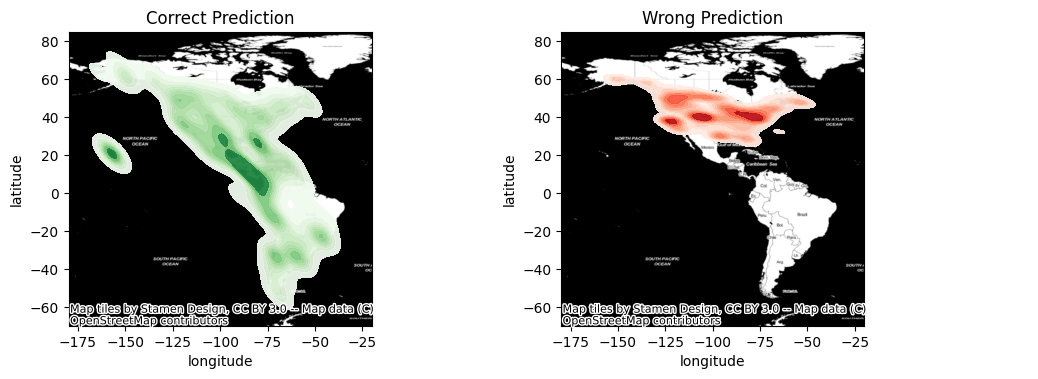

In [190]:
fig,ax = plt.subplots(1,2,figsize=(10,7))
plt.sca(ax[0])
a=sns.kdeplot(
    X_test.loc[right_index].longitude,
    X_test.loc[right_index].latitude, 
    cmap="Greens", shade=True,label = 'correct prediction',alpha=0.95
)
plt.title('Correct Prediction')
plt.xlim(-180,-20)
plt.ylim(-70,85)
plt.xlabel('longitude')
plt.ylabel('latitude')
cx.add_basemap(a,crs='EPSG:4326',source=cx.providers.Stamen.Toner)

plt.sca(ax[1])
a = sns.kdeplot(
    X_test.loc[wrong_index].longitude,
    X_test.loc[wrong_index].latitude, 
    cmap="Reds", shade=True,label = 'wrong prediction',alpha=0.95
)
plt.title('Wrong Prediction')

plt.xlim(-180,-20)
plt.ylim(-70,85)
plt.xlabel('longitude')
plt.ylabel('latitude')
cx.add_basemap(a,crs='EPSG:4326',source=cx.providers.Stamen.Toner)

plt.tight_layout()

plt.savefig('Error_analysis.png',dpi=500)

plt.show()




Index(['DOY', 'elevation_mean', 'duration_minutes', 'bio4', 'slope_mean',
       'bio7', 'bio19', 'bio2', 'bio17', 'tmin', 'bio11', 'bio6', 'bio8',
       'prec', 'bio3', 'bio9', 'bio18', 'slope_std', 'bio12', 'eastness_mean'],
      dtype='object')

(array([5.6297e+04, 9.5110e+03, 2.4240e+03, 7.2200e+02, 5.8600e+02,
        1.2500e+02, 5.1000e+01, 7.0000e+00, 1.5000e+01, 2.2000e+01]),
 array([1.0000e+00, 1.4490e+02, 2.8880e+02, 4.3270e+02, 5.7660e+02,
        7.2050e+02, 8.6440e+02, 1.0083e+03, 1.1522e+03, 1.2961e+03,
        1.4400e+03]),
 <BarContainer object of 10 artists>)

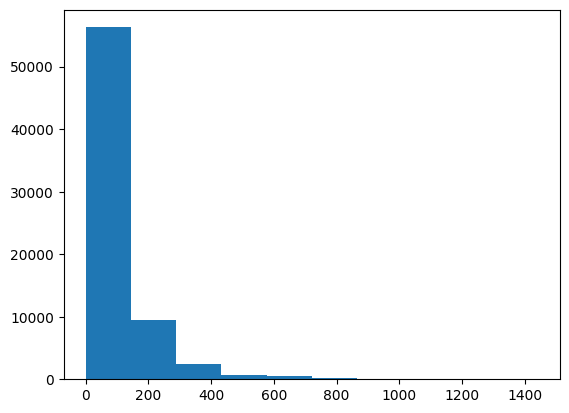

In [130]:
plt.hist(right_dist)

,duration_minutes,Traveling,Stationary,Area,obsvr_species_count,DOY,month,week,year,time_observation_started_minute_of_day,elevation_mean,slope_mean,eastness_mean,northness_mean,elevation_std,slope_std,eastness_std,northness_std,prec,tmax,tmin,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,closed_shrublands,closed_shrublands_ed,closed_shrublands_lpi,closed_shrublands_pd,cropland_or_natural_vegetation_mosaics,cropland_or_natural_vegetation_mosaics_ed,cropland_or_natural_vegetation_mosaics_lpi,cropland_or_natural_vegetation_mosaics_pd,croplands,croplands_ed,croplands_lpi,croplands_pd,deciduous_broadleaf_forests,deciduous_broadleaf_forests_ed,deciduous_broadleaf_forests_lpi,deciduous_broadleaf_forests_pd,deciduous_needleleaf_forests,deciduous_needleleaf_forests_ed,deciduous_needleleaf_forests_lpi,deciduous_needleleaf_forests_pd,evergreen_broadleaf_forests,evergreen_broadleaf_forests_ed,evergreen_broadleaf_forests_lpi,evergreen_broadleaf_forests_pd,evergreen_needleleaf_forests,evergreen_needleleaf_forests_ed,evergreen_needleleaf_forests_lpi,evergreen_needleleaf_forests_pd,grasslands,grasslands_ed,grasslands_lpi,grasslands_pd,mixed_forests,mixed_forests_ed,mixed_forests_lpi,mixed_forests_pd,non_vegetated_lands,non_vegetated_lands_ed,non_vegetated_lands_lpi,non_vegetated_lands_pd,open_shrublands,open_shrublands_ed,open_shrublands_lpi,open_shrublands_pd,permanent_wetlands,permanent_wetlands_ed,permanent_wetlands_lpi,permanent_wetlands_pd,savannas,savannas_ed,savannas_lpi,savannas_pd,urban_and_built_up_lands,urban_and_built_up_lands_ed,urban_and_built_up_lands_lpi,urban_and_built_up_lands_pd,water_bodies,water_bodies_ed,water_bodies_lpi,water_bodies_pd,woody_savannas,woody_savannas_ed,woody_savannas_lpi,woody_savannas_pd,entropy,longitude,latitude,sampling_event_identifier
80199,15.0,0,1,0,826,64,3,10,2018,1148,461.388900,0.335186,0.151684,-0.048522,0.998162,0.061199,0.019977,0.044556,35.582047,27.718832,12.099116,16.842863,13.402118,47.585770,549.45624,29.835794,1.671665,28.164130,20.503326,10.331827,22.971527,8.558167,651.199300,149.662930,4.028069,1680.765100,337.917450,23.312256,231.272980,23.312256,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,100.0,0.129404,0.129404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-64.375398,-33.106857,S43415298
35089,30.0,1,0,0,1083,26,1,4,2018,940,7.333334,1.323622,0.040357,-0.084696,0.505607,0.113869,0.120141,0.056075,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,100.0,0.129404,0.129404,0.000000,0.000000,0.000000,0.000000,-0.000000,-68.968472,12.120223,S42254703
125231,62.0,1,0,0,417,96,4,14,2018,495,764.444400,2.615817,0.044640,0.249003,0.600176,0.018775,0.074915,0.047259,25.584192,24.977730,16.255064,19.864655,9.228068,59.516293,209.88190,26.884370,11.379258,15.505113,22.492529,18.488459,22.487823,17.000450,1250.596200,297.876160,10.065291,8970.067000,734.370060,42.039482,734.370060,73.362950,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.916667,91.666667,0.129404,0.129404,0.000000,0.000

In [124]:
right_index



Int64Index([ 80199,  35089, 125231,  70683,  70345,  15985,  11973, 304917,
            180558,  90928,
            ...
            293490, 366453, 292502, 213097, 245394, 193727, 392488,  70263,
            124352, 269249],
           dtype='int64', length=69760)

Int64Index([ 80199,  35089, 125231,  70683,  70345,  15985,  11973, 304917,
            180558,  90928,
            ...
            293490, 366453, 292502, 213097, 245394, 193727, 392488,  70263,
            124352, 269249],
           dtype='int64', length=69760)

In [122]:
y_test_m.index[(y_test_m!=pred_m)]

Int64Index([226235, 167859,   1645, 274691,  71923, 282076,    652, 257856,
            175298, 152013,
            ...
            443053, 146792, 216075, 113404,   1173, 199070, 350723,  66259,
            170195,  96439],
           dtype='int64', length=19724)